In [1]:
from processed_image import ProcessedImage, read_from_dir, show_image_strip
imgs = list(read_from_dir('..\\Data\\LittleCarDb1'))
[str(img) for img in imgs[0:5]]

['ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-001_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-002_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-005_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-007_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-008_1.jpg (0 in cache)']

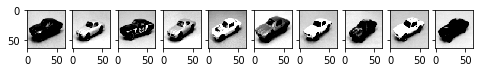

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 10, sharey=True, figsize=(8,1.5))
show_image_strip(imgs, axes)

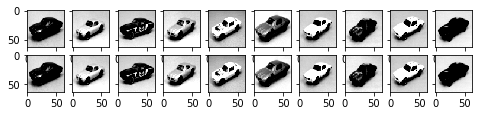

In [4]:
_, axes = plt.subplots(2, 10, sharey=True, figsize=(8,1.5))
processed_dict = {img.fullpath:img.get_processed_image() for img in imgs}
show_image_strip(imgs, axes, predicted_dict=processed_dict)

In [5]:
import numpy as np
x_train = [img.get_processed_image() for img in imgs]
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [6]:
# x_train_proc = \
# [np.clip(0.5 + (img - img.mean()) / (2.0*img.std()), 0.0, 1.0) for img in x_train]
# x_train_proc = np.array(x_train_proc)
x_train_proc = x_train
x_train[0].shape, x_train_proc[0].shape

((64, 64, 1), (64, 64, 1))

In [7]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [8]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
def build_encoded_layer(sz):
    # create encoder side
    input_img = Input(shape=(sz,sz,1))
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    # x = SpatialDropout2D(0.1)(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(32, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)
    return encoded_layer, input_img

def build_autoencoder(sz, optimizer, loss):
    encoded_layer, input_img = build_encoded_layer(sz)
    
    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)

    # generate latent vector Q(z|X)
    latent_dim = 8
    x = Flatten()(encoded_layer)
    x = Dense(32, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(32, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder

In [10]:
import random
x_test = np.array(random.sample(list(x_train_proc), int(len(x_train_proc)/10)))
x_train_proc.shape, x_test.shape

((171, 64, 64, 1), (17, 64, 64, 1))

In [11]:
vae, enc, dec = build_autoencoder(64, 'adadelta', 
                                      # 'categorical_crossentropy')
                                      'mean_squared_error')
                                      # 'binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   9248        max_pooling2d_1[0][0]            
_____________________________________

In [12]:
vae.fit(x_train_proc, x_train_proc, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

Instructions for updating:
Use tf.cast instead.
Train on 171 samples, validate on 17 samples
Epoch 1/1000
171/171 [==============================] - 4s 22ms/step - loss: 0.1390 - val_loss: 0.1308
Epoch 2/1000
171/171 [==============================] - 0s 363us/step - loss: 0.1385 - val_loss: 0.1303
Epoch 3/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1380 - val_loss: 0.1295
Epoch 4/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1374 - val_loss: 0.1290
Epoch 5/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1368 - val_loss: 0.1282
Epoch 6/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1361 - val_loss: 0.1274
Epoch 7/1000
171/171 [==============================] - 0s 333us/step - loss: 0.1353 - val_loss: 0.1264
Epoch 8/1000
171/171 [==============================] - 0s 327us/step - loss: 0.1345 - val_loss: 0.1255
Epoch 9/1000
171/171 [==============================] - 0s 328us/step - loss

Epoch 76/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0723 - val_loss: 0.0693
Epoch 77/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0716 - val_loss: 0.0738
Epoch 78/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0718 - val_loss: 0.0710
Epoch 79/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0722 - val_loss: 0.0734
Epoch 80/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0727 - val_loss: 0.0690
Epoch 81/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0724 - val_loss: 0.0731
Epoch 82/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0723 - val_loss: 0.0722
Epoch 83/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0724 - val_loss: 0.0739
Epoch 84/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0720 - val_loss: 0.0713
Epoch 85/1000
171/171 [==============================] 

Epoch 154/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0693 - val_loss: 0.0680
Epoch 155/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0696 - val_loss: 0.0702
Epoch 156/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0691 - val_loss: 0.0675
Epoch 157/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0693 - val_loss: 0.0696
Epoch 158/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0690 - val_loss: 0.0673
Epoch 159/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0691 - val_loss: 0.0710
Epoch 160/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0685 - val_loss: 0.0678
Epoch 161/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0689 - val_loss: 0.0693
Epoch 162/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0693 - val_loss: 0.0684
Epoch 163/1000
171/171 [======================

Epoch 232/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0683 - val_loss: 0.0674
Epoch 233/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0684 - val_loss: 0.0687
Epoch 234/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0680 - val_loss: 0.0679
Epoch 235/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0681 - val_loss: 0.0700
Epoch 236/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0677 - val_loss: 0.0677
Epoch 237/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0679 - val_loss: 0.0683
Epoch 238/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0678 - val_loss: 0.0683
Epoch 239/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0672 - val_loss: 0.0695
Epoch 240/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0674 - val_loss: 0.0667
Epoch 241/1000
171/171 [======================

Epoch 310/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0644 - val_loss: 0.0640
Epoch 311/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0639 - val_loss: 0.0674
Epoch 312/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0617 - val_loss: 0.0639
Epoch 313/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0636 - val_loss: 0.0671
Epoch 314/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0623 - val_loss: 0.0622
Epoch 315/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0634 - val_loss: 0.0623
Epoch 316/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0602 - val_loss: 0.0645
Epoch 317/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0610 - val_loss: 0.0623
Epoch 318/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0587 - val_loss: 0.0602
Epoch 319/1000
171/171 [======================

Epoch 388/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0489 - val_loss: 0.0516
Epoch 389/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0494 - val_loss: 0.0519
Epoch 390/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0487 - val_loss: 0.0522
Epoch 391/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0492 - val_loss: 0.0521
Epoch 392/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0489 - val_loss: 0.0523
Epoch 393/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0489 - val_loss: 0.0516
Epoch 394/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0480 - val_loss: 0.0508
Epoch 395/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0481 - val_loss: 0.0515
Epoch 396/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0479 - val_loss: 0.0499
Epoch 397/1000
171/171 [======================

Epoch 466/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0492 - val_loss: 0.0526
Epoch 467/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0483 - val_loss: 0.0524
Epoch 468/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0494 - val_loss: 0.0514
Epoch 469/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0482 - val_loss: 0.0502
Epoch 470/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0475 - val_loss: 0.0497
Epoch 471/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0469 - val_loss: 0.0491
Epoch 472/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0470 - val_loss: 0.0484
Epoch 473/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0462 - val_loss: 0.0485
Epoch 474/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0460 - val_loss: 0.0485
Epoch 475/1000
171/171 [======================

Epoch 544/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0447 - val_loss: 0.0491
Epoch 545/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0477 - val_loss: 0.0472
Epoch 546/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0445 - val_loss: 0.0467
Epoch 547/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0448 - val_loss: 0.0459
Epoch 548/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0436 - val_loss: 0.0466
Epoch 549/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0446 - val_loss: 0.0462
Epoch 550/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0439 - val_loss: 0.0478
Epoch 551/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0453 - val_loss: 0.0471
Epoch 552/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0444 - val_loss: 0.0470
Epoch 553/1000
171/171 [======================

Epoch 622/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0422 - val_loss: 0.0428
Epoch 623/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0411 - val_loss: 0.0431
Epoch 624/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0409 - val_loss: 0.0422
Epoch 625/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0408 - val_loss: 0.0436
Epoch 626/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0410 - val_loss: 0.0432
Epoch 627/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0417 - val_loss: 0.0449
Epoch 628/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0422 - val_loss: 0.0450
Epoch 629/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0436 - val_loss: 0.0477
Epoch 630/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0442 - val_loss: 0.0461
Epoch 631/1000
171/171 [======================

Epoch 700/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0407 - val_loss: 0.0419
Epoch 701/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0402 - val_loss: 0.0424
Epoch 702/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0407 - val_loss: 0.0439
Epoch 703/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0416 - val_loss: 0.0448
Epoch 704/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0434 - val_loss: 0.0439
Epoch 705/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0412 - val_loss: 0.0433
Epoch 706/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0421 - val_loss: 0.0429
Epoch 707/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0402 - val_loss: 0.0420
Epoch 708/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0404 - val_loss: 0.0429
Epoch 709/1000
171/171 [======================

Epoch 778/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0392 - val_loss: 0.0416
Epoch 779/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0386 - val_loss: 0.0401
Epoch 780/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0388 - val_loss: 0.0418
Epoch 781/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0385 - val_loss: 0.0402
Epoch 782/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0389 - val_loss: 0.0420
Epoch 783/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0388 - val_loss: 0.0401
Epoch 784/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0391 - val_loss: 0.0427
Epoch 785/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0391 - val_loss: 0.0402
Epoch 786/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0391 - val_loss: 0.0425
Epoch 787/1000
171/171 [======================

Epoch 856/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0371 - val_loss: 0.0397
Epoch 857/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0378 - val_loss: 0.0409
Epoch 858/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0382 - val_loss: 0.0413
Epoch 859/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0396 - val_loss: 0.0412
Epoch 860/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0385 - val_loss: 0.0409
Epoch 861/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0390 - val_loss: 0.0402
Epoch 862/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0376 - val_loss: 0.0397
Epoch 863/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0377 - val_loss: 0.0395
Epoch 864/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0370 - val_loss: 0.0391
Epoch 865/1000
171/171 [======================

Epoch 934/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0380 - val_loss: 0.0413
Epoch 935/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0391 - val_loss: 0.0396
Epoch 936/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0372 - val_loss: 0.0397
Epoch 937/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0379 - val_loss: 0.0396
Epoch 938/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0371 - val_loss: 0.0391
Epoch 939/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0376 - val_loss: 0.0402
Epoch 940/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0373 - val_loss: 0.0395
Epoch 941/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0383 - val_loss: 0.0421
Epoch 942/1000
171/171 [==============================] - 0s 357us/step - loss: 0.0383 - val_loss: 0.0404
Epoch 943/1000
171/171 [======================

(17, 64, 64, 1) -> (17, 8) -> (17, 64, 64, 1)


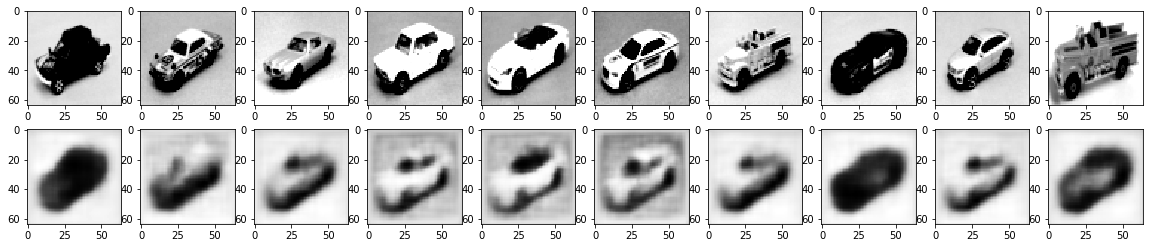

In [13]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        # plt.imshow(colors.hsv_to_rgb(original[i].reshape(128, 128, 3)))     
        # re_original = original[i].reshape(128,128)
        plt.imshow(original[i].reshape(64, 64), cmap='gray')
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded[i].reshape(64, 64), cmap='gray')
        # plt.imshow(colors.hsv_to_rgb
        # (decoded[i].reshape(128, 128, 3)))
        # plt.imshow(colors.hsv_to_rgb(decode_this_image))
    plt.show() # block=True)
# decoded_imgs = vae.predict(x_test)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
np.zeros((1,2,3,2))[:,:,:,1].std()